## Constructing and training of the VAE
#### In this notebook the neural network will be constructed and using the decoder of it, the requested dataset will be generated.

#### Imports

In [17]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Lambda, Dropout
from tensorflow.keras.losses import mse, BinaryCrossentropy
from tensorflow.keras import backend as K

from convertors import momentums_to_angles

#### Notebook environment setup

In [18]:
%matplotlib inline

In [19]:
pd.options.display.max_columns = 15
np.random.seed(111)
tf.random.set_seed(111)

#### Provide sampling layer for the VAE

In [20]:
def sample(args):
    """ Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

#### Import the dataset with no smearing, to train the network.

In [21]:
df = pd.read_csv('Data/monte_carlo_dataset.csv')

dataset = df.to_numpy()[:, 1:]
dataset.shape

(100000, 10)

#### Getting dimensions of the dataset. Will serve as parameters to our network

In [22]:
num_of_samples = dataset.shape[0]
input_shape = dataset.shape[1]

#### Setting properties for the VAE

In [23]:
E_tot = 400
activation_encoder_hidden = 'relu'
size_latent = 4

#### Initialise scaler for (de)normalisation

In [24]:
scaler = MinMaxScaler()
scaler.fit(dataset)

MinMaxScaler()

#### Defining functions for normalisation & denormalisation

In [25]:
def normalise(data):
    return scaler.transform(data)

def denormalise(data):
    return scaler.inverse_transform(data)

## Constructing the Variational Auto-Encoder(VAE)
#### Define the encoder and the decoder

In [26]:
encoder_input = Input(shape=input_shape, name="encoder_input")
encoder_hidden = Dense(7, activation=activation_encoder_hidden, name="encoder_hidden")(encoder_input)
z_mean = Dense(size_latent, activation='linear', name="mean")(encoder_hidden)
z_log_var = Dense(size_latent, activation='linear', name="logvariance")(encoder_hidden)
z = Lambda(sample, output_shape=(size_latent,), name="z")([z_mean, z_log_var])

encoder = Model(encoder_input, [z_mean, z_log_var, z], name="encoder")

decoder_input = Input(shape=(size_latent,), name="decoder_input")
decoder_hidden = Dense(7, activation=activation_encoder_hidden, name="decoder_hidden")(decoder_input)
# dropped_hidden = Dropout(0.7, name="dropout")(decoder_hidden)
decoder_output = Dense(input_shape, activation="linear", name="decoder_outputs")(decoder_hidden)

decoder = Model(decoder_input, decoder_output, name="decoder")

outputs = decoder(encoder(encoder_input)[2])

In [27]:
vae = load_model('./Model/vae.hdf5')

#### Plot architecture

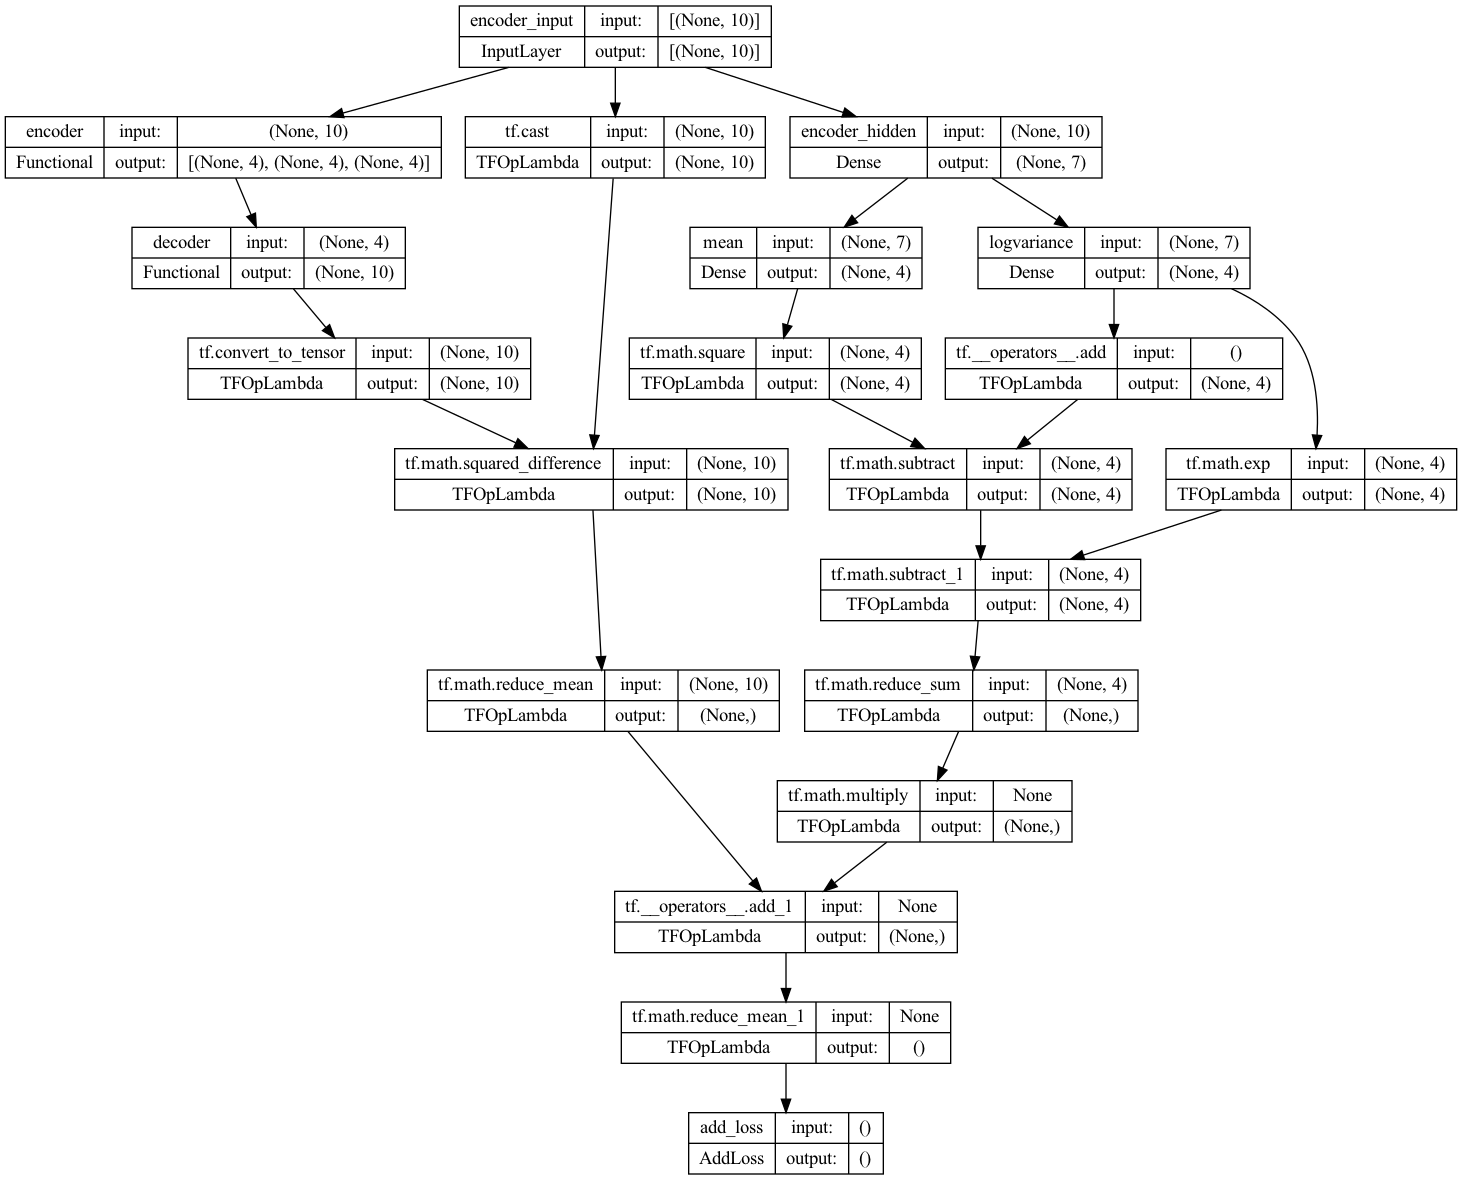

In [28]:
tf.keras.utils.plot_model(vae, to_file='VAE.png', show_shapes=True)